In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time, os
import json

In [98]:
from types import SimpleNamespace

In [99]:
import statistics

In [100]:
import numpy as np

# Retrieving Data From Steamspy API

Additional data is available through the API for steampy that is unable to be scraped such as:

In [38]:
response = requests.get('http://steamspy.com/api.php?request=all&page=1')

In [101]:
response

<Response [200]>

In [41]:
df = pd.DataFrame(response.json()).T

In [42]:
df.head(1)

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
240760,240760,Wasteland 2: Director's Cut,inXile Entertainment,inXile Entertainment,,6499,1385,0,"500,000 .. 1,000,000",877,0,681,0,2999,2999,0,32


### The API has 44 pages. According to the restraints dictated by SteamSpy, there must be a 60 second delay between requests.


In [44]:
for i in range(44):
    response = requests.get(f'http://steamspy.com/api.php?request=all&page={i}')
    list = response.json()
    df = pd.concat([df,(pd.DataFrame(list).T)])
    time.sleep(60)
    
    
    


In [47]:
df.shape

(42773, 17)

In [46]:
df.drop_duplicates(inplace=True)

In [48]:
df.rename(columns={'name':'title'},inplace=True)

In [49]:
df.head(1)

,appid,title,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
240760,240760,Wasteland 2: Director's Cut,inXile Entertainment,inXile Entertainment,,6499,1385,0,"500,000 .. 1,000,000",877,0,681,0,2999,2999,0,32


### Owners
Owners are listed as a range. for modeling, I am creating a quick function -medianator - to find the median.

In [50]:
def medianator (raw):
    raw2 = (raw.replace(',','').replace('.','').split())
    nums = [int(s) for s in raw2]
    return statistics.median(nums)

In [51]:
df['owners_median'] = df.owners.map(medianator)

In [341]:
df.head()

,title,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,ccu,owners_median
240760,Wasteland 2: Director's Cut,6499,1385,"500,000 .. 1,000,000",877,0,681,0,32,750000.0
241540,State of Decay,14963,2744,"500,000 .. 1,000,000",1304,0,1461,0,18,750000.0
8800,Civilization IV: Beyond the Sword,2694,100,"500,000 .. 1,000,000",3395,196,4337,196,1576,750000.0
70600,Worms Ultimate Mayhem,3481,471,"500,000 .. 1,000,000",213,0,121,0,50,750000.0
238260,Pinball Arcade,2536,944,"500,000 .. 1,000,000",649,0,32,0,42,750000.0


### Saving the data from the API as steamspyapi.csv

In [342]:
df.to_csv(r'/Users/michaelharnett/Desktop/metis\steamspyapi.csv')

In [60]:
reviewsdf = pd.read_csv('data/reviewsdf.csv')

In [61]:
reviewsdf.shape

(5793, 92)

In [15]:
df.drop(columns=['year_released'],inplace=True)

In [65]:
df.drop(columns = ['appid', 'developer', 'publisher', 'score_rank',
                  'userscore', 'price', 'initialprice', 'discount',
                  'owners'], inplace=True)

In [68]:
reviewsdf.drop(columns=['link', 'release_date', 'review_rating',
                     'num_languages', 'tags', 'genres','publisher',
                     'top_pubs'], inplace=True)

In [224]:
#ownerdf = pd.merge(reviewsdf,df[['title','owners_median','positive','negative']], on=['title'])

In [69]:
ownerdf = pd.merge(reviewsdf,df, on=['title'])

In [348]:
ownerdf.shape

(5188, 92)

In [70]:
ownerdf.head(1)

,title,been_sale,orig_price,num_reviews,num_tags,num_genres,year_released,languages_filled,rating_val,Singleplayer_tag,...,tinyBuild,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,ccu,owners_median
0,OUTRIDERS,0,59.99,36837,20.0,3.0,2021,13.0,6,1,...,0,26922,14940,"1,000,000 .. 2,000,000",2074,585,1600,279,23037,1500000.0


In [94]:
ownerdf.columns

Index(['title', 'owners_median', 'positive', 'negative', 'num_reviews',
       'been_sale', 'orig_price', 'num_tags', 'num_genres', 'year_released',
       'languages_filled', 'rating_val', 'Singleplayer_tag', 'Indie_tag',
       'Action_tag', 'Adventure_tag', 'Casual_tag', 'Strategy_tag',
       'Multiplayer_tag', 'RPG_tag', 'Simulation_tag', 'Atmospheric_tag',
       'Horror_tag', '2D_tag', 'Soundtrack_tag', 'Great_tag', 'Story_tag',
       'Rich_tag', 'World_tag', 'Shooter_tag', 'Puzzle_tag', 'TurnBased_tag',
       'Open_tag', 'FirstPerson_tag', 'Survival_tag', 'Fantasy_tag',
       'Funny_tag', 'Coop_tag', 'Platformer_tag', 'Early_tag', 'Access_tag',
       'Sim_tag', 'Indie_genre', 'Action_genre', 'Adventure_genre',
       'Casual_genre', 'Simulation_genre', 'Strategy_genre', 'RPG_genre',
       '_genre', 'Early_genre', 'Access_genre', 'Games_genre', 'Sports_genre',
       'Racing_genre', 'Studios_genre', 'Entertainment_genre',
       'Massively_genre', 'Multiplayer_genre', 'Stud

In [91]:
cols = ownerdf.columns.tolist()

In [92]:
cols.insert(4, cols.pop(cols.index('num_reviews')))

In [93]:
ownerdf = ownerdf[cols]

In [340]:
#ownerdf.info()



In [112]:
#converting new columns into integers. since theyre from JSON they imported as objects

ints_list = ['positive','negative', 'average_forever', 'average_2weeks',
            'median_forever', 'median_2weeks', 'ccu']
for things in ints_list:
    ownerdf[things] = ownerdf[things].astype(int)


In [148]:
bring2front = ['average_forever', 'average_2weeks',
               'median_forever', 'median_2weeks', 'ccu']

cols = ownerdf.columns.tolist()

for items in bring2front:
    cols.insert(5, cols.pop(cols.index(items)))

ownerdf = ownerdf[cols]

## Saving merged df as ownerdf

In [345]:
ownerdf.to_csv(r'/Users/MichaelHarnett/Desktop/METIS/Steam_Analysis\ownerdf.csv', index=False)

# Modeling
using ownership as target


In [150]:
X, y = ownerdf.iloc[:,2:], ownerdf.iloc[:,1]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [152]:
lr = LinearRegression()

In [153]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.8042508113629196

In [154]:
lr.score(X_val, y_val)

0.7627400280940863

In [156]:
train_preds = lr.predict(X_train)

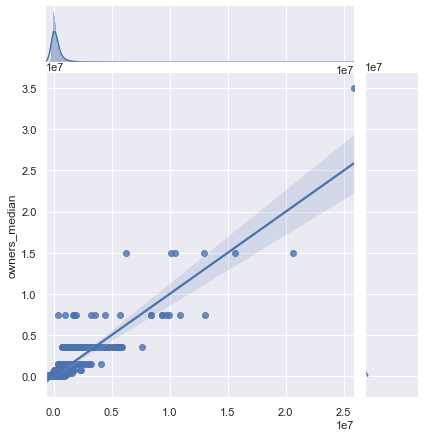

In [157]:
sns.jointplot(x=train_preds,y=y_train, kind='reg')

In [158]:
rmse = mean_squared_error(y_train, train_preds, squared=False)
print(rmse)
mae = mean_absolute_error(y_train, train_preds)
print(mae)

540540.3440522465
221729.19511907827


In [160]:
ownerdf.corr()

,owners_median,positive,negative,num_reviews,ccu,median_2weeks,median_forever,average_2weeks,average_forever,been_sale,...,Electronic Arts,Paradox Interactive,SEGA,Sokpop Collective,Square Enix,THQ Nordic,Ubisoft,Winged Cloud,other,tinyBuild
owners_median,1.000000,0.901520,0.712095,0.899763,0.755281,0.087061,0.065027,0.108491,0.289349,-0.047430,...,0.015933,0.039023,0.016020,-0.018557,0.019136,0.002951,0.015807,-0.012249,-0.042996,0.001988
positive,0.901520,1.000000,0.614339,0.944267,0.714906,0.098773,0.067173,0.132630,0.303426,-0.050414,...,0.004677,0.040404,0.005714,-0.016910,0.003861,-0.006539,0.005969,-0.012946,-0.023070,-0.004318
negative,0.712095,0.614339,1.000000,0.769682,0.915485,0.040239,0.072567,0.058557,0.246623,-0.018396,...,0.001525,0.013237,-0.000381,-0.006290,0.005194,-0.001218,0.001250,-0.004560,-0.011547,-0.001674
num_reviews,0.899763,0.944267,0.769682,1.000000,0.819459,0.086086,0.072660,0.117588,0.304447,-0.045369,...,0.003238,0.034384,0.003899,-0.015010,0.003992,-0.005584,0.004822,-0.011430,-0.019794,-0.004035
ccu,0.755281,0.714906,0.915485,0.819459,1.000000,0.074106,0.091284,0.101015,0.318940,-0.024445,...,0.007390,0.042519,0.028297,-0.007401,0.012508,-0.005133,-0.003356,-0.006259,-0.021765,-0.005270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THQ Nordic,0.002951,-0.006539,-0.001218,-0.005584,-0.005133,-0.004153,-0.000608,-0.004743,-0.003819,0.007921,...,-0.006746,-0.007171,-0.007171,-0.007670,-0.007861,1.000000,-0.005134,-0.006524,-0.281035,-0.006855
Ubisoft,0.015807,0.005969,0.001250,0.004822,-0.003356,-0.005264,0.009553,-0.004404,0.011968,-0.024515,...,-0.004574,-0.004862,-0.004862,-0.005200,-0.005330,-0.005134,1.000000,-0.004423,-0.190538,-0.004648
Winged Cloud,-0.012249,-0.012946,-0.004560,-0.011430,-0.006259,-0.008232,-0.009489,-0.008221,-0.014319,0.180420,...,-0.005812,-0.006178,-0.006178,-0.006608,-0.006772,-0.006524,-0.004423,1.000000,-0.242106,-0.005905
other,-0.042996,-0.023070,-0.011547,-0.019794,-0.021765,-0.043192,-0.077995,-0.043328,-0.096451,-0.040721,...,-0.250364,-0.266130,-0.266130,-0.284643,-0.291729,-0.281035,-0.190538,-0.242106,1.000000,-0.254395


In [197]:
X, y = ownerdf.iloc[:,2:15], ownerdf.iloc[:,1]

In [343]:
ownerdf.owners_median.value_counts()

10000.0       2063
35000.0        776
350000.0       582
75000.0        561
150000.0       506
750000.0       314
1500000.0      203
3500000.0      134
7500000.0       36
15000000.0       9
35000000.0       3
75000000.0       1
Name: owners_median, dtype: int64

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [199]:
lr = LinearRegression()

In [200]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7961642648028194

In [201]:
lr.score(X_val, y_val)

0.7612925423117416

<AxesSubplot:>

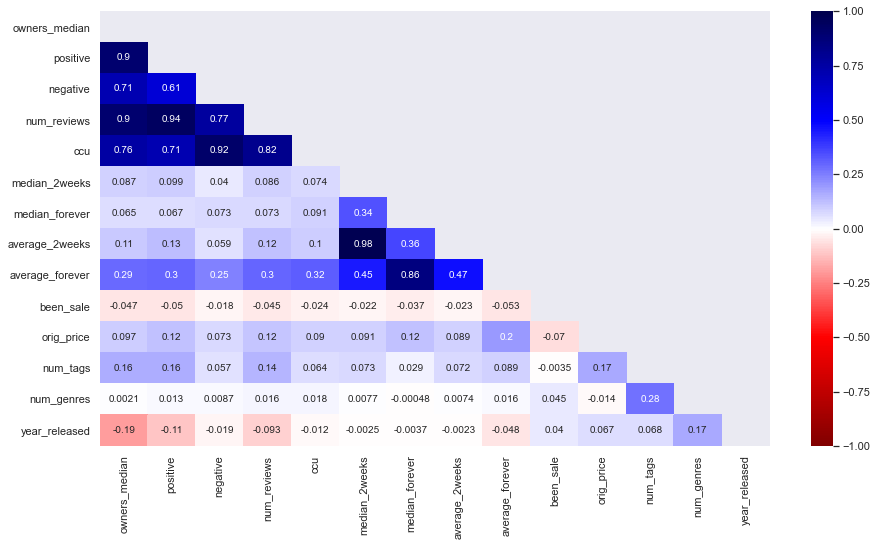

In [208]:
heatmapdf = ownerdf.iloc[:,1:15]
plt.figure(figsize(15,8))
upper = np.triu(heatmapdf.corr())
sns.heatmap(heatmapdf.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper)



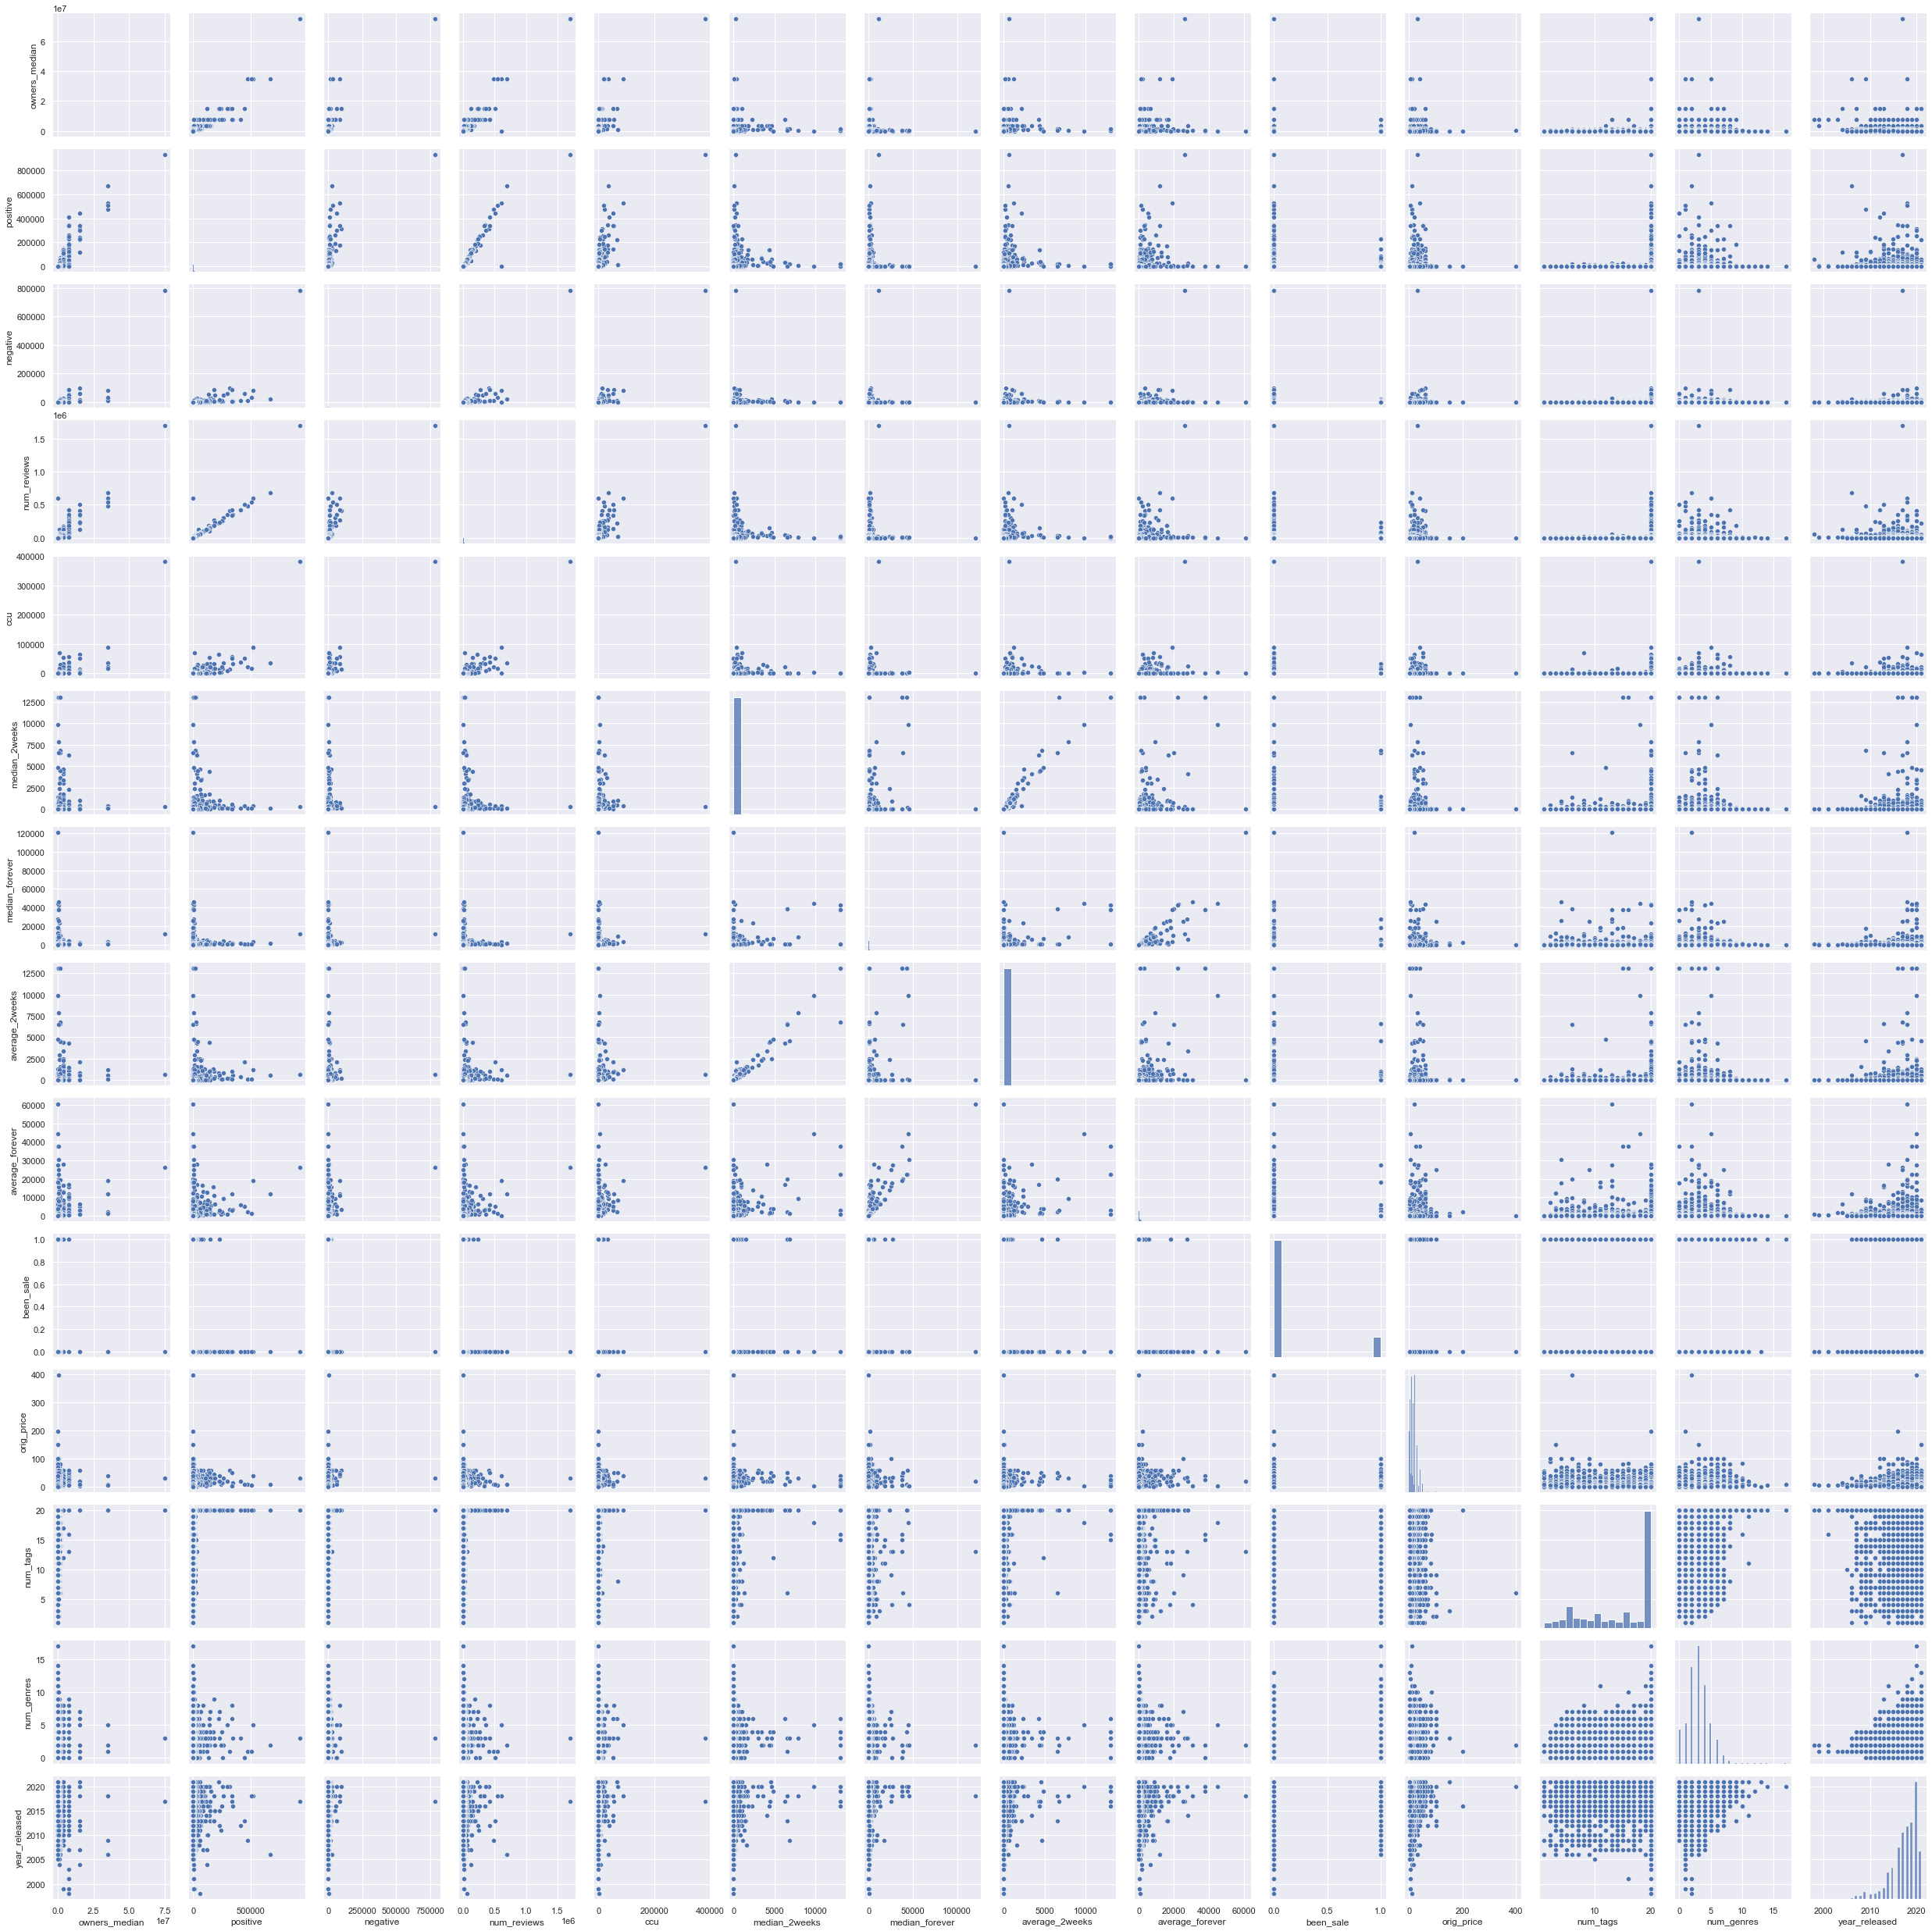

In [209]:
sns.pairplot(heatmapdf)

In [171]:
import scipy.stats as stats

In [172]:
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(X,y)
    pred = rgr.predict(X)
    
    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

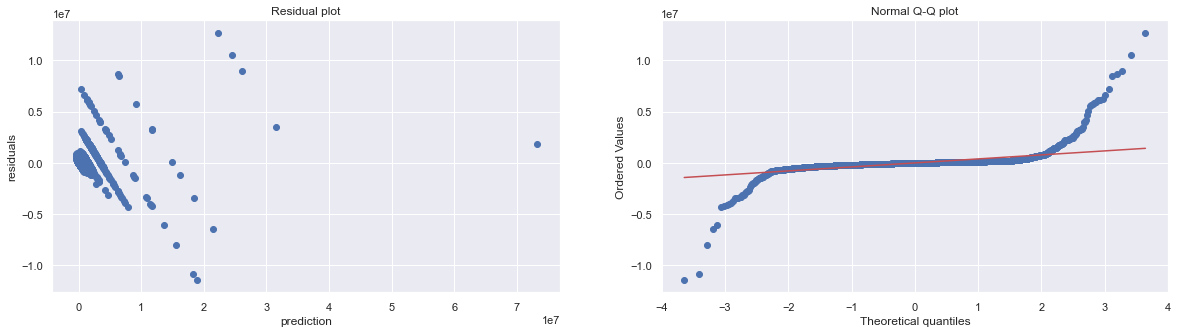

In [173]:
diagnostic_plot(X, y)

In [174]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [175]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [177]:
vif(ownerdf.iloc[:, 2:])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


positive         13.945982
negative          8.724745
num_reviews      20.274831
ccu               9.208352
median_2weeks    26.279191
                   ...    
THQ Nordic        2.665985
Ubisoft           1.767111
Winged Cloud      2.312724
other            17.760406
tinyBuild         2.427541
Length: 90, dtype: float64

# Modeling 2
reviews as target

In [296]:
cols = ownerdf2.columns.tolist()
cols.insert(1, cols.pop(cols.index('num_reviews')))
reviewsdf2 = ownerdf2[cols]

In [332]:
X, y = reviewsdf2.iloc[:,2:], reviewsdf2.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [333]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9929205897273292

In [334]:
X_train.shape

(3105, 90)

In [335]:
lr.score(X_val, y_val)

0.9981950748557044

In [288]:
reviewsdf2.owners_median.value_counts()

10000.0      2063
35000.0       776
350000.0      582
75000.0       561
150000.0      506
750000.0      314
1500000.0     203
3500000.0     134
7500000.0      36
Name: owners_median, dtype: int64

In [336]:
train_preds = lr.predict(X_train)
rmse = mean_squared_error(y_train, train_preds, squared=False)
print(rmse)
mae = mean_absolute_error(y_train, train_preds)
print(mae)

1591.586291191274
252.61597258391635


<AxesSubplot:>

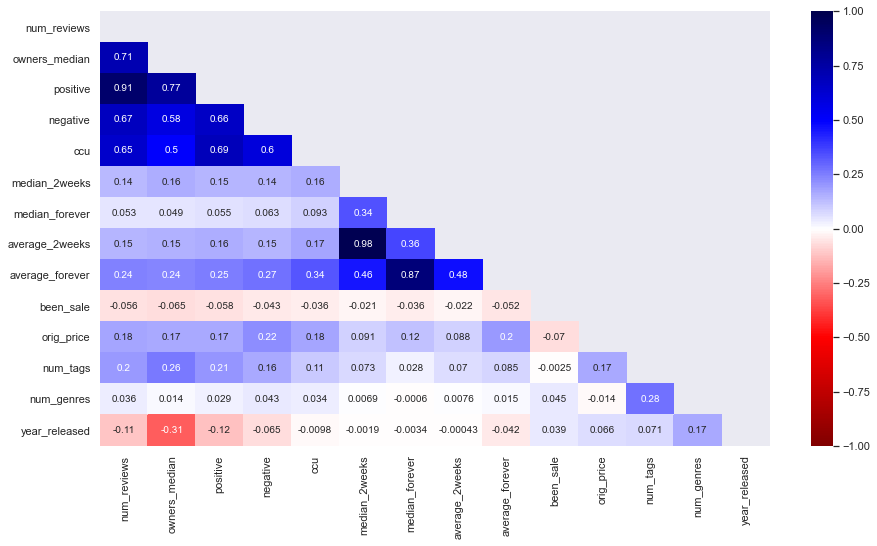

In [293]:
heatmapdf = reviewsdf2.iloc[:,1:15]
plt.figure(figsize(15,8))
upper = np.triu(heatmapdf.corr())
sns.heatmap(heatmapdf.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper)


In [337]:
trian_preds = lr.predict(X_train)

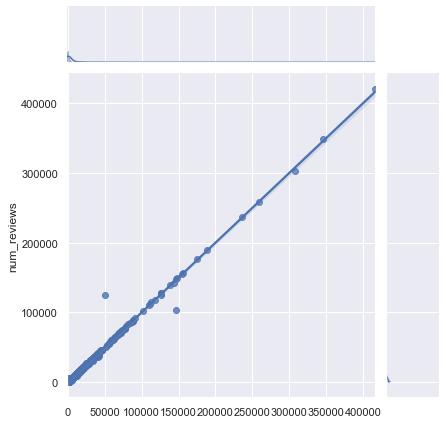

In [338]:
sns.jointplot(x=train_preds,y=y_train, kind='reg')

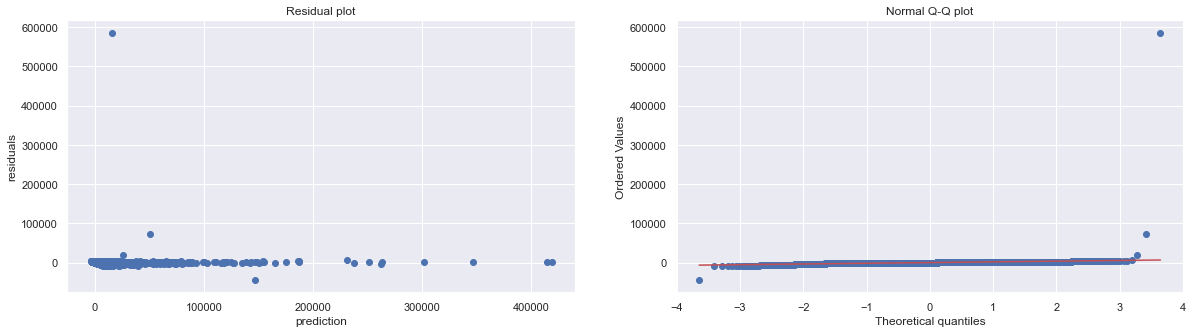

In [339]:
diagnostic_plot(X, y)

In [194]:
vif(reviewsdf2.iloc[:, 2:])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


owners_median     7.795690
positive          6.692282
negative          7.540237
ccu               9.224832
median_2weeks    26.530636
                   ...    
THQ Nordic        2.666430
Ubisoft           1.767395
Winged Cloud      2.313029
other            17.766075
tinyBuild         2.427558
Length: 90, dtype: float64

# Modeling 3
dropping outliers in target values

In [212]:
ownerdf.owners_median.value_counts()


10000.0       2063
35000.0        776
350000.0       582
75000.0        561
150000.0       506
750000.0       314
1500000.0      203
3500000.0      134
7500000.0       36
15000000.0       9
35000000.0       4
75000000.0       1
Name: owners_median, dtype: int64

In [247]:
ownerdf[ownerdf.owners_median == 75000000.0]

,title,owners_median,positive,negative,num_reviews,ccu,median_2weeks,median_forever,average_2weeks,average_forever,...,Electronic Arts,Paradox Interactive,SEGA,Sokpop Collective,Square Enix,THQ Nordic,Ubisoft,Winged Cloud,other,tinyBuild
48,PLAYERUNKNOWN'S BATTLEGROUNDS,75000000.0,927347,784222,1701229,382408,275,11437,669,26222,...,0,0,0,0,0,0,0,0,1,0


In [248]:
ownerdf2= ownerdf.drop(index=48)

In [249]:
ownerdf2[ownerdf2.owners_median == 35000000.0]

,title,owners_median,positive,negative,num_reviews,ccu,median_2weeks,median_forever,average_2weeks,average_forever,...,Electronic Arts,Paradox Interactive,SEGA,Sokpop Collective,Square Enix,THQ Nordic,Ubisoft,Winged Cloud,other,tinyBuild
7,Rust,35000000.0,523021,83858,601739,88725,321,2747,1166,18917,...,0,0,0,0,0,0,0,0,1,0
60,Garry's Mod,35000000.0,667842,23937,687446,35885,93,1430,551,11789,...,0,0,0,0,0,0,0,0,1,0
68,Left 4 Dead 2,35000000.0,471316,13216,481091,20779,97,517,121,1847,...,0,0,0,0,0,0,0,0,1,0


In [250]:
ownerdf2.drop(index=[7,60,68],inplace=True)

In [251]:
droplist = ownerdf2[ownerdf2.owners_median == 15000000.0].index

In [252]:
ownerdf2.drop(index=droplist,inplace=True)

In [253]:
ownerdf2.owners_median.value_counts()

10000.0      2063
35000.0       776
350000.0      582
75000.0       561
150000.0      506
750000.0      314
1500000.0     203
3500000.0     134
7500000.0      36
Name: owners_median, dtype: int64

In [254]:
X, y = ownerdf2.iloc[:,2:], ownerdf2.iloc[:,1]

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [257]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.6582484261554927

In [258]:
lr.score(X_val,y_val)

0.7326813144273423

In [259]:
train_preds = lr.predict(X_train)

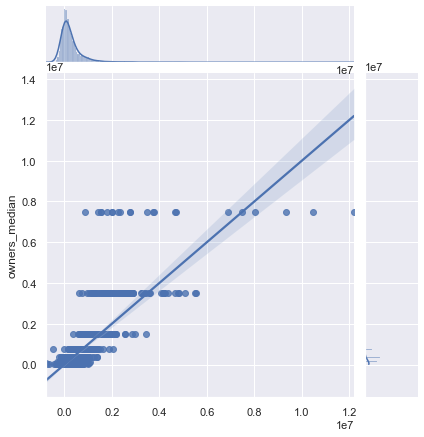

In [260]:
sns.jointplot(x=train_preds,y=y_train, kind='reg')

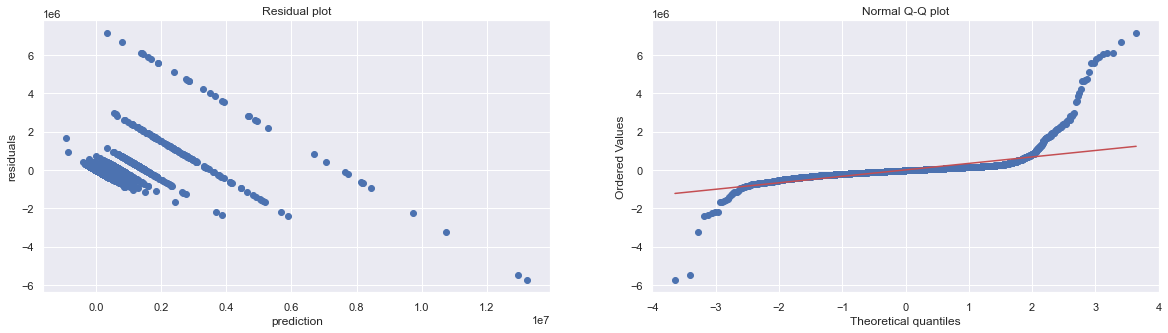

In [261]:
diagnostic_plot(X, y)

In [346]:
ownerdf.columns

Index(['title', 'owners_median', 'positive', 'negative', 'num_reviews', 'ccu',
       'median_2weeks', 'median_forever', 'average_2weeks', 'average_forever',
       'been_sale', 'orig_price', 'num_tags', 'num_genres', 'year_released',
       'languages_filled', 'rating_val', 'Singleplayer_tag', 'Indie_tag',
       'Action_tag', 'Adventure_tag', 'Casual_tag', 'Strategy_tag',
       'Multiplayer_tag', 'RPG_tag', 'Simulation_tag', 'Atmospheric_tag',
       'Horror_tag', '2D_tag', 'Soundtrack_tag', 'Great_tag', 'Story_tag',
       'Rich_tag', 'World_tag', 'Shooter_tag', 'Puzzle_tag', 'TurnBased_tag',
       'Open_tag', 'FirstPerson_tag', 'Survival_tag', 'Fantasy_tag',
       'Funny_tag', 'Coop_tag', 'Platformer_tag', 'Early_tag', 'Access_tag',
       'Sim_tag', 'Indie_genre', 'Action_genre', 'Adventure_genre',
       'Casual_genre', 'Simulation_genre', 'Strategy_genre', 'RPG_genre',
       '_genre', 'Early_genre', 'Access_genre', 'Games_genre', 'Sports_genre',
       'Racing_genre', 'Studi